In [1]:
import mxnet as mx
import numpy
import matplotlib.pyplot as plt
import pandas
import logging
import csv
from datetime import datetime

In [2]:
batch_size = 100

In [3]:
# Columns of training dataset to be used. We will seggregate csv file into label and training data.
usecols = [i for i in range(1, 785)];

label_csv = numpy.loadtxt('../data/train_orig.csv', delimiter = ',', usecols = 0, skiprows = 1, dtype = int)
train_csv = numpy.loadtxt('../data/train_orig.csv', delimiter = ',', usecols = usecols, skiprows = 1, dtype = float)


In [4]:
# Columns of test dataset to be used. For test data all the columns will be utilized.
testcols = [i for i in range(0, 785)]

test_iter = mx.io.CSVIter(data_csv = '../data/test.csv', data_shape = (784, ), batch_size = batch_size)

In [5]:
# Convert NumPy Array to NDArrayIter that MXNet sym utilizes
train_iter = mx.io.NDArrayIter(data = train_csv, label = label_csv, batch_size = batch_size)

In [6]:
# Lets look at the distribution of training data
#xbins = [x for x in range(0, 11)]
#plt.hist(mnist['train_label'], xbins)
#plt.show()

In [7]:
data = mx.sym.var('data')

In [8]:
# The first fully-connected layer and the corresponding activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

# The second fully-connected layer and the corresponding activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

fc3  = mx.sym.FullyConnected(data=act2, num_hidden = 256)
act3 = mx.sym.Activation(data=fc3, act_type="tanh")

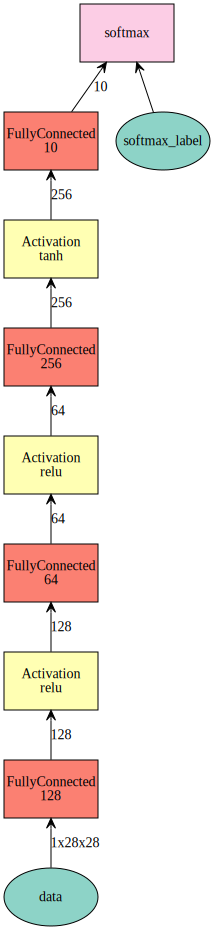

In [9]:
# MNIST has 10 classes
fc4  = mx.sym.FullyConnected(data=act3, num_hidden=10)
# Softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data=fc4, name='softmax')
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [10]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on CPU
mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())

mlp_model.fit(train_iter,  # train data
              eval_data=None,  # validation data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.1},  # use fixed learning rate
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 50), # output progress for each 100 data batches
              num_epoch=1)  # train for at most 10 dataset passes


INFO:root:Epoch[0] Batch [50]	Speed: 44227.10 samples/sec	accuracy=0.219216
INFO:root:Epoch[0] Batch [100]	Speed: 46950.18 samples/sec	accuracy=0.510600
INFO:root:Epoch[0] Batch [150]	Speed: 46721.53 samples/sec	accuracy=0.739800
INFO:root:Epoch[0] Batch [200]	Speed: 48863.48 samples/sec	accuracy=0.830800
INFO:root:Epoch[0] Batch [250]	Speed: 47782.44 samples/sec	accuracy=0.881000
INFO:root:Epoch[0] Batch [300]	Speed: 47272.33 samples/sec	accuracy=0.892000
INFO:root:Epoch[0] Batch [350]	Speed: 47001.32 samples/sec	accuracy=0.908800
INFO:root:Epoch[0] Batch [400]	Speed: 45169.59 samples/sec	accuracy=0.924200
INFO:root:Epoch[0] Train-accuracy=0.926842
INFO:root:Epoch[0] Time cost=0.919


In [11]:
prob = mlp_model.predict(test_iter)
lenOutput = prob.shape[0]


In [12]:
outputFileName = '../output/output.' + str(datetime.now()) + ".csv";
with open(outputFileName, 'w') as outputFile:
    outputWriter = csv.writer(outputFile, delimiter=',');
    outputWriter.writerow(['ImageId','Label']);
    imageId = 1;
    for i in range(0, lenOutput-1):
        output = prob[i]
        outputWriter.writerow([str(imageId)] + [str(numpy.argmax(output.asnumpy()))]);
        imageId += 1